# Multiclass classification
In this notebook we will make a multiclass classification, the starting paper is as follows: [A Deep Learning Approach for Viral DNA Sequence Classification using Genetic Algorithm](https://www.researchgate.net/publication/363276607_A_Deep_Learning_Approach_for_Viral_DNA_Sequence_Classification_using_Genetic_Algorithm)

We will propose different models for the task on a different dataset


#### Definition of common import and functions


In [1]:
import json, os
import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras.src.layers import (
    BatchNormalization,
    MultiHeadAttention,
    LayerNormalization, 
    GlobalMaxPooling1D,
    ReLU,
    MaxPooling1D
)

from keras.src.losses import SparseCategoricalCrossentropy, sparse_categorical_crossentropy
from keras.src.optimizers import Adamax, LossScaleOptimizer

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

df_path = '/Volumes/Seagate Bas/Vito/ML/Dataset/MulticlassDatasets/'
df_saved = './Saved/'
epochs = 20
sequence_df = None

## Models

In [2]:
def get_model(dimension, num_classes):
    inputs = keras.layers.Input(shape=dimension)
    x = keras.layers.Masking(mask_value=-1.0)(inputs)
    x = keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.LSTM(1024)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Self-Attention layer
    # Attention mechanism
    #attention = keras.layers.Dense(1, activation='tanh')(x)
    #attention = keras.layers.Flatten()(attention)
    #attention = keras.layers.Activation('softmax')(attention)
    #attention = keras.layers.RepeatVector(dimension[1])(attention)
    #attention = keras.layers.Permute([2, 1])(attention)
    #attention = keras.layers.Multiply()([x, attention])
    #x = keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)
    
    x = keras.layers.Dense(256, kernel_regularizer='l2')(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs=inputs, outputs=x)
    return model


### Unbalanced data set loading

In [4]:
df = None
with open(df_path+'UnBalancedDataset.jsonl') as f:
  for index, line in tqdm(enumerate(f)):
      data = json.loads(line)
      if df is None:
          df = pd.DataFrame(data=data, index=[0])
      else:
          df.loc[len(df)] = data
df.head()

0it [00:00, ?it/s]

,Accession,Release Date,Species,Genus,Family,Molecule Type,Length,Sequence Type,Host,Collection Date,Sequence
0,OQ599922.1,2023-06-20T00:00:00Z,Banfec circovirus 1,Circovirus,Circoviridae,ssDNA(+/-),1680,GenBank,Canis latrans,2021-04-24,TATTACCGGAGACTTTGGAACCGTGGAACAGGCCGATCTGTAATGA...
1,OQ599923.1,2023-06-20T00:00:00Z,Banfec circovirus 1,Circovirus,Circoviridae,ssDNA(+/-),1680,GenBank,Canis latrans,2021-04-23,TATTACCGGAGACTTTGGAACCGTGGAACAGGCCGATCTGTAATGA...
2,OQ599924.1,2023-06-20T00:00:00Z,Banfec circovirus 2,Circovirus,Circoviridae,ssDNA(+/-),2079,GenBank,Canis latrans,2021-04-23,TAGTATTACCCGGCACCTTGACACAGACACTTCGACACACTGCTGC...
3,OQ241209.1,2023-06-19T00:00:00Z,Circovirus porcine2,Circovirus,Circoviridae,ssDNA(+/-),1768,GenBank,Sus scrofa,2021,ACCAGCGCACTTCGGCAGCGGCAGCACCTCGGCAGCACCTCGGCAG...
4,OQ241210.1,2023-06-19T00:00:00Z,Circovirus porcine2,Circovirus,Circoviridae,ssDNA(+/-),1767,GenBank,Sus scrofa,2021,ACCAGCGCACTTCGGCAGCGGCAGCACCTCGGCAGCACCTCAGCAG...


In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Accession,Release Date,Species,Genus,Family,Molecule Type,Length,Sequence Type,Host,Collection Date,Sequence
0,KR233980.1,2015-05-19T00:00:00Z,Alphainfluenzavirus influenzae,Alphainfluenzavirus,Orthomyxoviridae,ssRNA(-),2290,GenBank,Meleagris gallopavo,2015-03-26,ATGGATGTCAATCCGACTTTACTTTTCTTGAAAGTTCCAGCGCAAA...
1,MT205771.1,2022-09-19T00:00:00Z,Circoviridae sp.,nan,Circoviridae,ssDNA(+/-),2607,GenBank,nan,2012,ATGAATTGTAAATGGATAAAGTTGAACCTGGTCCGGCTTCGAACCA...
2,KF652077.1,2013-12-14T00:00:00Z,Jatropha mosaic Lucknow virus,Begomovirus,Geminiviridae,ssDNA(+/-),2844,GenBank,Jatropha multifida,2013-05-10,ACCGGATGGCCGCTATTTTTTTAACGTGGACCCCACAACAGACAGA...
3,MF978395.1,2017-10-15T00:00:00Z,Alphainfluenzavirus influenzae,Alphainfluenzavirus,Orthomyxoviridae,ssRNA(-),2233,GenBank,Feliformia,2016,AGCGAAAGCAGGTACTGATTCAAAATGGAAGACTTTGTGCGACAGT...
4,MF674506.1,2017-09-13T00:00:00Z,Hepatitis B virus,Orthohepadnavirus,Hepadnaviridae,dsDNA-RT,3215,GenBank,Homo sapiens,2014-04-07,CTCCACCACTTTCCACCAAACTCTTCAAGATCCCAGAGTCAGGGCC...


In [6]:
labels = df['Family']
X = df['Sequence']
X

0        ATGGATGTCAATCCGACTTTACTTTTCTTGAAAGTTCCAGCGCAAA...
1        ATGAATTGTAAATGGATAAAGTTGAACCTGGTCCGGCTTCGAACCA...
2        ACCGGATGGCCGCTATTTTTTTAACGTGGACCCCACAACAGACAGA...
3        AGCGAAAGCAGGTACTGATTCAAAATGGAAGACTTTGTGCGACAGT...
4        CTCCACCACTTTCCACCAAACTCTTCAAGATCCCAGAGTCAGGGCC...
                               ...                        
47958    TCCAAAATGGAAGACTTTGTGCGACAATGCTTCAATCCAATGATCA...
47959    ACCGGATGGCCGCGCCCGACAAAGTAAGTGGACCCCATTAGATGGC...
47960    CTCCAGCACATTCCACCAAGCTCTGCTAGATCCCAGAGTGCGGGGC...
47961    AGCAAAAGCAGGGTAGATAATCACTCACTGAGTGACATCAACATCA...
47962    ACCGGATGGCCGCGATTTTTTGGTGTCCTCTATCCCGGCCCAGGCC...
Name: Sequence, Length: 47963, dtype: object

I see the maximum length of the sequence so that I can make the dataset containing sequence and target

In [7]:
max_len = []
for el in X:
    max_len.append(len(el))
max_len = max(max_len)
max_len

3999

In [8]:
cols =[]

for col in range(max_len):
    cols.append('nucleotide_' + str(col))


In [9]:
def encoder_sequence(seq):
  if seq == 'A':
    return 1
  elif seq == 'C':
    return 2
  elif seq == 'G':
    return 3
  elif seq == 'T':
    return 4
  else:
    return -1

def decode_sequence(seq):
  if seq == 1:
    return 'A'
  elif seq == 2:
    return 'C'
  elif seq == 3:
    return 'G'
  elif seq == 4:
    return 'T'
  else:
    return None

In [10]:
sequence_df = pd.DataFrame(columns = cols)

for row in tqdm(X):
    sequence = {}
    row = list(row)
    for index, i in enumerate(cols):
        if index < len(row):
            sequence[i] = encoder_sequence(row[index])
        else:
          sequence[i] = None

    sequence_df.loc[len(sequence_df)] = sequence

sequence_df.head()

  0%|          | 0/47963 [00:00<?, ?it/s]

,nucleotide_0,nucleotide_1,nucleotide_2,nucleotide_3,nucleotide_4,nucleotide_5,nucleotide_6,nucleotide_7,nucleotide_8,nucleotide_9,...,nucleotide_3989,nucleotide_3990,nucleotide_3991,nucleotide_3992,nucleotide_3993,nucleotide_3994,nucleotide_3995,nucleotide_3996,nucleotide_3997,nucleotide_3998
0,1,4,3,3,1,4,3,4,2,1,...,None,None,None,None,None,None,None,None,None,None
1,1,4,3,1,1,4,4,3,4,1,...,None,None,None,None,None,None,None,None,None,None
2,1,2,2,3,3,1,4,3,3,2,...,None,None,None,None,None,None,None,None,None,None
3,1,3,2,3,1,1,1,3,2,1,...,None,None,None,None,None,None,None,None,None,None
4,2,4,2,2,1,2,2,1,2,4,...,None,None,None,None,None,None,None,None,None,None


In [11]:
sequence_df['Target'] = labels
sequence_df.head()
sequence_df.to_json(df_path+'ProcessedUnBalancedDataset.jsonl', orient='records', lines=True)

/var/folders/6_/rd9ym68j6r71z04zhvmw821r0000gn/T/ipykernel_3078/676103479.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequence_df['Target'] = labels


In [3]:
# If all previous step are performed, skip to this cell
if os.path.exists(df_path+'ProcessedUnBalancedDataset.jsonl') and sequence_df is None:
    print('Loading data from ProcessedUnBalancedDataset.jsonl...')
    sequence_df = pd.read_json(df_path+'ProcessedUnBalancedDataset.jsonl', orient='records', lines=True)
else:
    print('Dataset or dataset already created not exists, run previous step.')

labels = sequence_df['Target']
sequence_df = sequence_df.drop(['Target'], axis=1)
sequence_df.head()

Loading data from ProcessedUnBalancedDataset.jsonl...


,nucleotide_0,nucleotide_1,nucleotide_2,nucleotide_3,nucleotide_4,nucleotide_5,nucleotide_6,nucleotide_7,nucleotide_8,nucleotide_9,...,nucleotide_3989,nucleotide_3990,nucleotide_3991,nucleotide_3992,nucleotide_3993,nucleotide_3994,nucleotide_3995,nucleotide_3996,nucleotide_3997,nucleotide_3998
0,1,4,3,3,1,4,3,4,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4,3,1,1,4,4,3,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,2,3,3,1,4,3,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,2,3,1,1,1,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,4,2,2,1,2,2,1,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
labels.value_counts()

Target
Geminiviridae       15183
Hepadnaviridae      11360
Orthomyxoviridae    11344
Circoviridae        10076
Name: count, dtype: int64

## Convert to numerical and fit the model

In [5]:
encoder_y = LabelEncoder()
scaler = MinMaxScaler()
X = sequence_df.to_numpy().astype(np.float32)
y = labels.to_numpy()

# fit the encoder for the label
encoder_y.fit(y)
# scaling the feature
X = scaler.fit_transform(X)

X.shape, y.shape

((47963, 3999), (47963,))

In [6]:
dimension = (X.shape[1], 1)
dimension

(3999, 1)

In [7]:
n_class = len(labels.unique())
# param for the model
batch_size = 8
n_class

4

In [8]:
model = get_model(dimension, n_class)
model.compile(
    optimizer=LossScaleOptimizer(
        Adamax(
        learning_rate=0.002,
        )
    ),
    loss=SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

/Users/vitolosavio/Desktop/Machine_learning_Code/Machine-learning-project/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3999, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 3999, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3995, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1997, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1993, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 996, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1024)           │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,031,684 (19.19 MB)

 Trainable params: 5,029,636 (19.19 MB)

 Non-trainable params: 2,048 (8.00 KB)

## Continual learning
For fit the model we suse the technique of continual learning, so we split the dataset into n batch and 
we fit the model for every batch saving the most performant model.

In [9]:
n_batch = 30
start = 0
step = int(len(X)/n_batch) 
end = step

all_df = []

for i in range(n_batch):
    all_df.append(
        {
            'X': X[start:end],
            'y': y[start:end]
        }
    )
    start += step
    end += step

step, end

(1598, 49538)

In [ ]:
best_accuracy = 0
# best model to save
best_model = None

# metrics of the best classification for the evaluation of the best model
best_pred = None
gt_pred = None

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    verbose=1,
    mode="auto",
    start_from_epoch=0,
)

all_accuracy = []
all_loss = []
for df in all_df:
    X_f, X_test, y_f, y_test = train_test_split(df['X'], df['y'], test_size=0.2, random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1, random_state=42)
    
    X_train = np.nan_to_num(X_train, nan=-1.0)
    X_val = np.nan_to_num(X_val, nan=-1.0)
    X_test = np.nan_to_num(X_test, nan=-1.0)
    
    # reshape for three-dimensional space
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    y_train = encoder_y.transform(y_train).astype(np.float32)
    y_val = encoder_y.transform(y_val).astype(np.float32)
    y_test = encoder_y.transform(y_test).astype(np.float32)
    

    # fit the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=1,
        batch_size=batch_size,
        callbacks=[early_stopping],
    )

    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    
    all_accuracy.append(acc)
    all_loss.append(loss)
    # get the prediction        
    y_pred = model.predict(X_test, verbose=0)
    y_pred = [np.argmax(y) for y in y_pred]
    y_pred = encoder_y.inverse_transform(y_pred)
    
    if acc > best_accuracy:
        print(f'Saving best model with Accuracy of {acc*100:.2f}%...')
        best_accuracy = acc
        best_model = model
        best_pred = y_pred
        gt_pred = y_test
    
# plot the fit metrics
fig, (ax1, ax2) = plt.subplots(1, 2, squeeze=False)
# summarize history for accuracy
ax1.plot(all_accuracy)
ax1.legend(['test'])
ax1.set_title('Accuracy')
ax2.plot(all_loss)
ax2.legend(['test'])
ax2.set_title('Loss')
fig.show()

Epoch 1/20


/Users/vitolosavio/Desktop/Machine_learning_Code/Machine-learning-project/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
print(classification_report(y_true=gt_pred, y_pred=best_pred, zero_division=0))

In [ ]:
cm = confusion_matrix(y_true=gt_pred, y_pred=best_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels.unique()
)

disp.plot()

In [ ]:
# saving the best model
best_model.save(df_saved+'BestModelContinualLearning.keras')

## Cross validation

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 301s 6s/step - accuracy: 0.4725 - loss: 1.2710 - val_accuracy: 0.3636 - val_loss: 10.3200
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - accuracy: 0.4762 - loss: 1.2653 - val_accuracy: 0.3239 - val_loss: 2.1812
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.4978 - loss: 1.2340 - val_accuracy: 0.3239 - val_loss: 10.9542
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2678 - loss: 12.4445
Saving best model with Accuracy of 26.67%...
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.4851 - loss: 1.2599 - val_accuracy: 0.1136 - val_loss: 44.5735
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - accuracy: 0.4802 - loss: 1.2765 - val_accuracy: 0.4148 - val_loss: 38.6422
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4324 - loss: 36.3511
Saving best model with Accuracy of 43.59%...
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - 

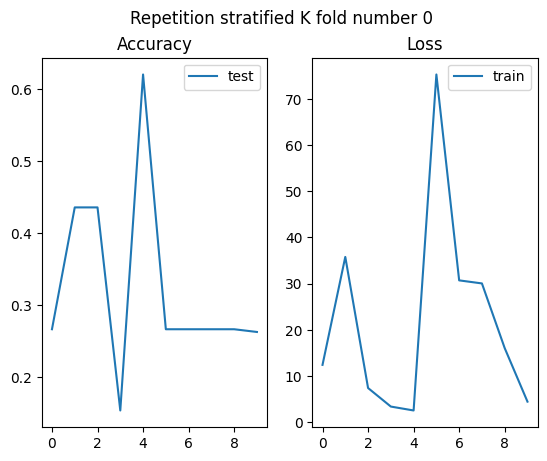

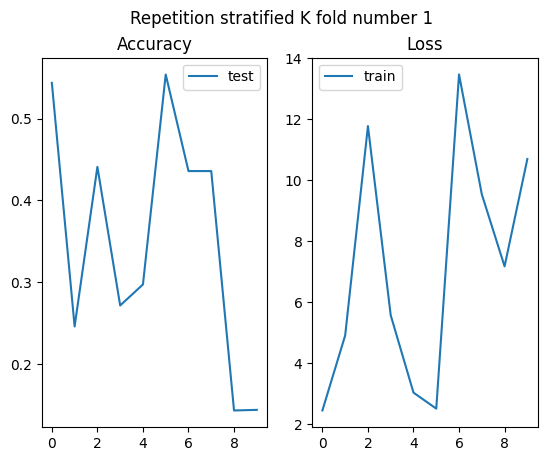

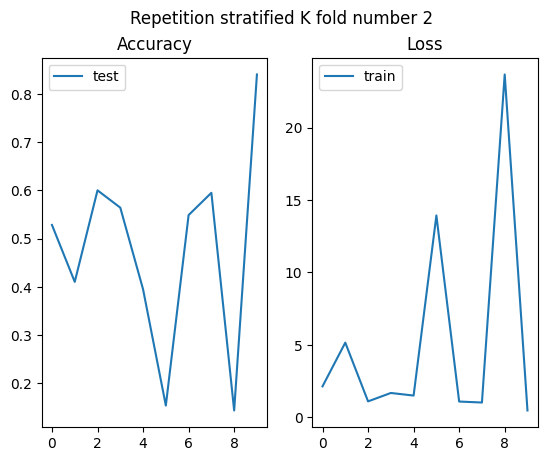

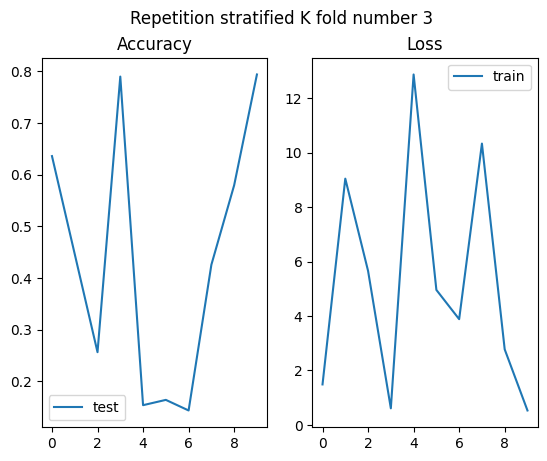

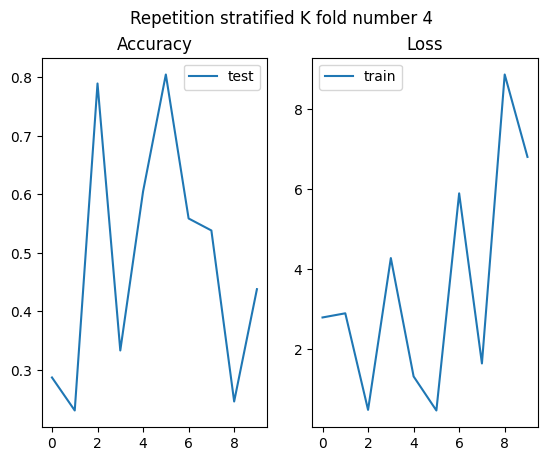

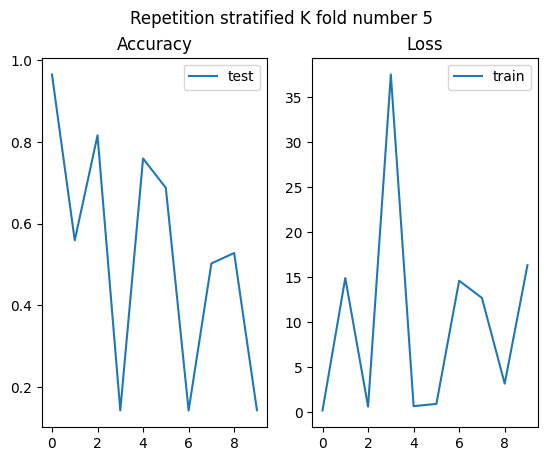

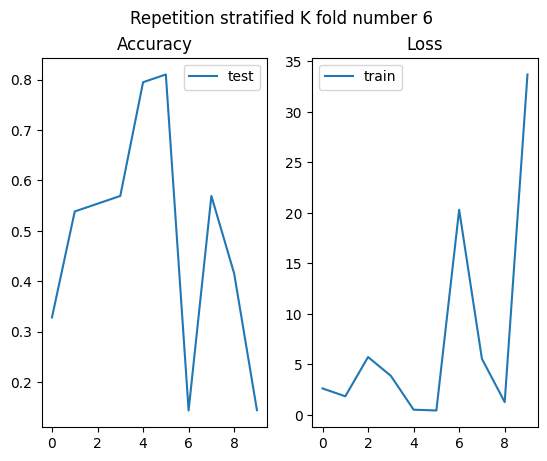

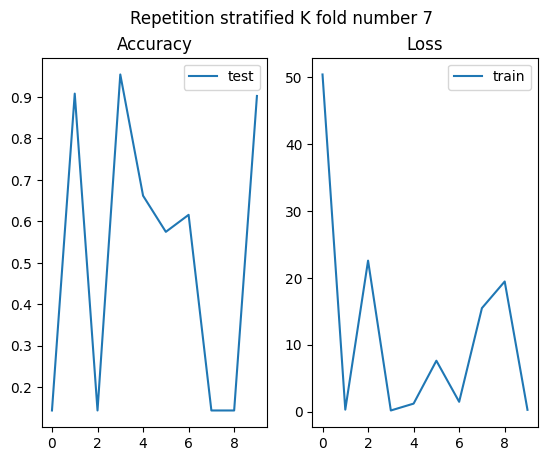

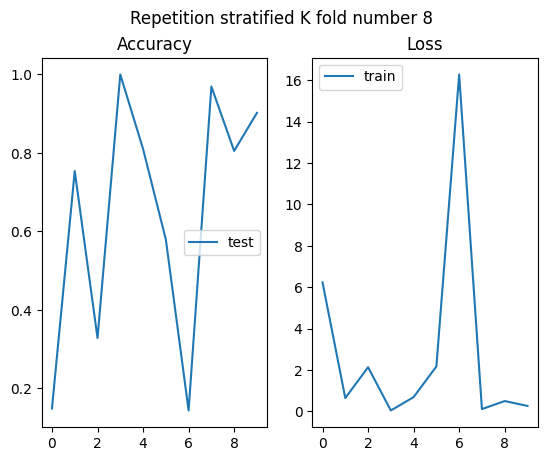

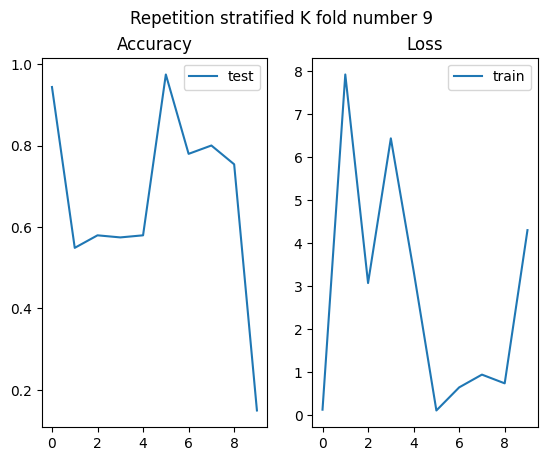

In [90]:
best_accuracy = 0
# repeatition of stratified k fold
n_repeatition = 10
# best model to save
best_model = None

# metrics of the best classification for the evaluation of the best model
best_pred = None
gt_pred = None

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    verbose=0,
    mode="auto",
    start_from_epoch=0,
)
loss = sparse_categorical_crossentropy

# repeated stratified k fold cross validation 
for i in range(n_repeatition):
    # Stratified K-Fold cross validation
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    accuracy_history = []
    loss_test = []
    for train_index, test_index in skf.split(X, y):
        # Get the train data and split it in train and val
        X_f, y_f = X[train_index],y[train_index]
        X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1, random_state=42)
        X_test = X[test_index]
        
        X_train = np.nan_to_num(X_train, nan=-1.0)
        X_val = np.nan_to_num(X_val, nan=-1.0)
        X_test = np.nan_to_num(X_test, nan=-1.0)
        
        # reshape for three-dimensional space
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
        y_train = encoder_y.transform(y_train).astype(np.float32)
        y_val = encoder_y.transform(y_val).astype(np.float32)
        
    
        # fit the model
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            verbose=0,
            callbacks=[early_stopping],
        )

        loss, acc = model.evaluate(X_test, encoder_y.transform(y[test_index]), verbose=0)

        # get the prediction        
        y_pred = model.predict(X_test, verbose=0)
        y_pred = [np.argmax(y) for y in y_pred]
        y_pred = encoder_y.inverse_transform(y_pred)
        
        loss_test.append(loss)
        accuracy_history.append(acc)
        
        if acc > best_accuracy:
            print(f'Saving best model with Accuracy of {acc*100:.2f}%...')
            best_accuracy = acc
            best_model = model
            best_pred = y_pred
            gt_pred = y[test_index]
    
    # plot the fit metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, squeeze=False)
    # summarize history for accuracy
    ax1.plot(accuracy_history)
    ax1.legend(['test'])
    ax1.set_title('Accuracy')
    ax2.plot(loss_test)
    ax2.legend(['test'])
    ax2.set_title('Loss')
    fig.suptitle(f'Repetition stratified K fold number {i}')
    fig.show()

In [91]:
print(classification_report(y_true=gt_pred, y_pred=best_pred, zero_division=0))

                 precision    recall  f1-score   support

   Circoviridae       1.00      1.00      1.00        30
  Geminiviridae       1.00      1.00      1.00        85
  Phenuiviridae       1.00      1.00      1.00        28
Spinareoviridae       1.00      1.00      1.00        52

       accuracy                           1.00       195
      macro avg       1.00      1.00      1.00       195
   weighted avg       1.00      1.00      1.00       195



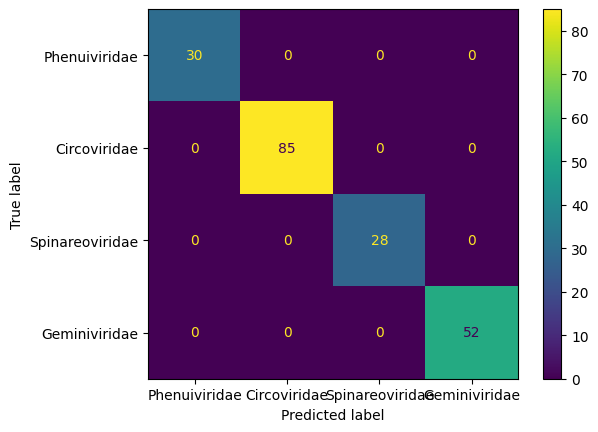

In [96]:
cm = confusion_matrix(y_true=gt_pred, y_pred=best_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels.unique()
)

disp.plot()

In [119]:
# saving the best model
best_model.save(df_saved+'UnBalancedBestModel.keras')

## Explainability of the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels.to_numpy(), test_size=0.2, random_state=42)

In [ ]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR

int_mod=TSR(model, X_train.shape[-2],X_train.shape[-1], method='IG',mode='time')
item= np.array([X_test[0,:,:]])
label=int(np.argmax(y_test[0]))

exp=int_mod.explain(item,labels=label,TSR =True)

%matplotlib inline  
int_mod.plot(np.array([X_test[0,:,:]]),exp)